In [3]:
import os
import cv2
import glob
import time
import copy
import shutil
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

## 資料處理，從標記檔中取得行人影像並依照 reid 分類

In [2]:
def getImagesInDir(dir_path):
    img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng']  # acceptable image suffixes
    image_list = []
    for img_format in img_formats:
        for filename in glob.glob(dir_path + f'/*.{img_format}'):
            image_list.append(filename)
    return image_list

In [3]:
classes = ['pedestrian']
img_dir = 'person_reid_datasets/train/JPEGImages/'
ann_dir = 'person_reid_datasets/train/Annotations/'
image_paths = getImagesInDir(img_dir)
out_dir = 'reid/data'

In [4]:
# 創建資料夾
if os.path.exists(out_dir.split('/')[0]):
    shutil.rmtree(out_dir.split('/')[0])  # delete output folder
os.makedirs(out_dir)  # make new output folder

In [5]:
for img_path in tqdm(image_paths, total=len(image_paths)):
    # read image
    img = cv2.imread(img_path)
    
    basename = os.path.basename(img_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(ann_dir + '/' + basename_no_ext + '.xml')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    cnt=0
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        reid = obj.find('reid').text[:-2]
        crop_img = img[int(b[2]):int(b[3]), int(b[0]):int(b[1]), :]
        out_reid_dir = os.path.join(out_dir, reid)
        if not os.path.exists(out_reid_dir):
            os.mkdir(out_reid_dir)
        cv2.imwrite(os.path.join(out_reid_dir, basename_no_ext+'_'+str(cnt))+'.jpg', crop_img)
        cnt+=1

100%|██████████| 723/723 [00:08<00:00, 86.99it/s] 


In [4]:
out_dir = 'reid/data'
x_data_list = []
y_data_list = []
for roots, _, files in os.walk(out_dir):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(each)
            y_data_list.append(roots.split("/")[-1])
data = pd.DataFrame({'file':x_data_list, 'class':y_data_list})
data.head()

,file,class
0,c6s2_058318_4.jpg,624
1,c5s2_049580_3.jpg,624
2,c5s2_070777_4.jpg,624
3,c4s4_050685_1.jpg,624
4,c6s2_058393_1.jpg,624


In [5]:
data.groupby('class').count().sort_values(['file'])

,file
class,
285,1
545,1
714,1
344,2
618,2
...,...
192,45
55,46
173,48


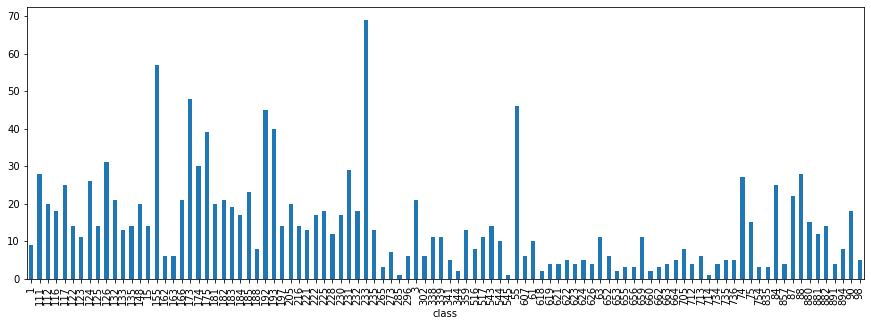

In [6]:
data.groupby('class').count().plot(kind='bar', figsize=(15, 5), legend=False)

In [7]:
class_num = len(data.groupby('class').count())

## 切分訓練集和驗證集

In [8]:
def make_dir(source, target):
    dir_names = os.listdir(source)
    for names in dir_names:
        for i in ['train', 'valid']:
            path = target + '/' + i + '/' + names
            if not os.path.exists(path):
                os.makedirs(path)
                
def divideTrainValid(source, target):
    pic_name = os.listdir(source)
    
    for classes in pic_name:
        pic_classes_name = os.listdir(os.path.join(source, classes))
        if '.ipynb_checkpoints' in pic_classes_name:
            pic_classes_name.remove('.ipynb_checkpoints')
        random.shuffle(pic_classes_name)
        
        if len(pic_classes_name) == 1:
            train_list = pic_classes_name[:]
            valid_list = pic_classes_name[:]
        else:
            train_list = pic_classes_name[0:int(0.9*len(pic_classes_name))]
            valid_list = pic_classes_name[int(0.9*len(pic_classes_name)):]
        
        for train_pic in train_list:
            shutil.copyfile(source + '/' + classes + '/' + train_pic, target + '/train/' + classes + '/' + train_pic)
        for valid_pic in valid_list:
            shutil.copyfile(source + '/' + classes + '/' + valid_pic, target + '/valid/' + classes + '/' + valid_pic)
            
filepath = 'reid/data'
dist = 'reid'
make_dir(filepath, dist)
divideTrainValid(filepath, dist)

## 讀入 Pre-trained Model

In [1]:
import torchvision

In [2]:
torchvision.__version__

'0.10.0+cu111'

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, class_num, )
model_ft = model_ft.to(device)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [10]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 決定 Pre-trained Model 參數量

In [8]:
for param in model_ft.parameters():
    param.requires_grad = False

for name, param in model_ft.named_parameters():
    if name.split('.')[0] in ['layer4', 'fc']:
        param.requires_grad = True
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

## Data Augmentation

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'reid'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [10]:
dataset_sizes

{'train': 1247, 'valid': 195}

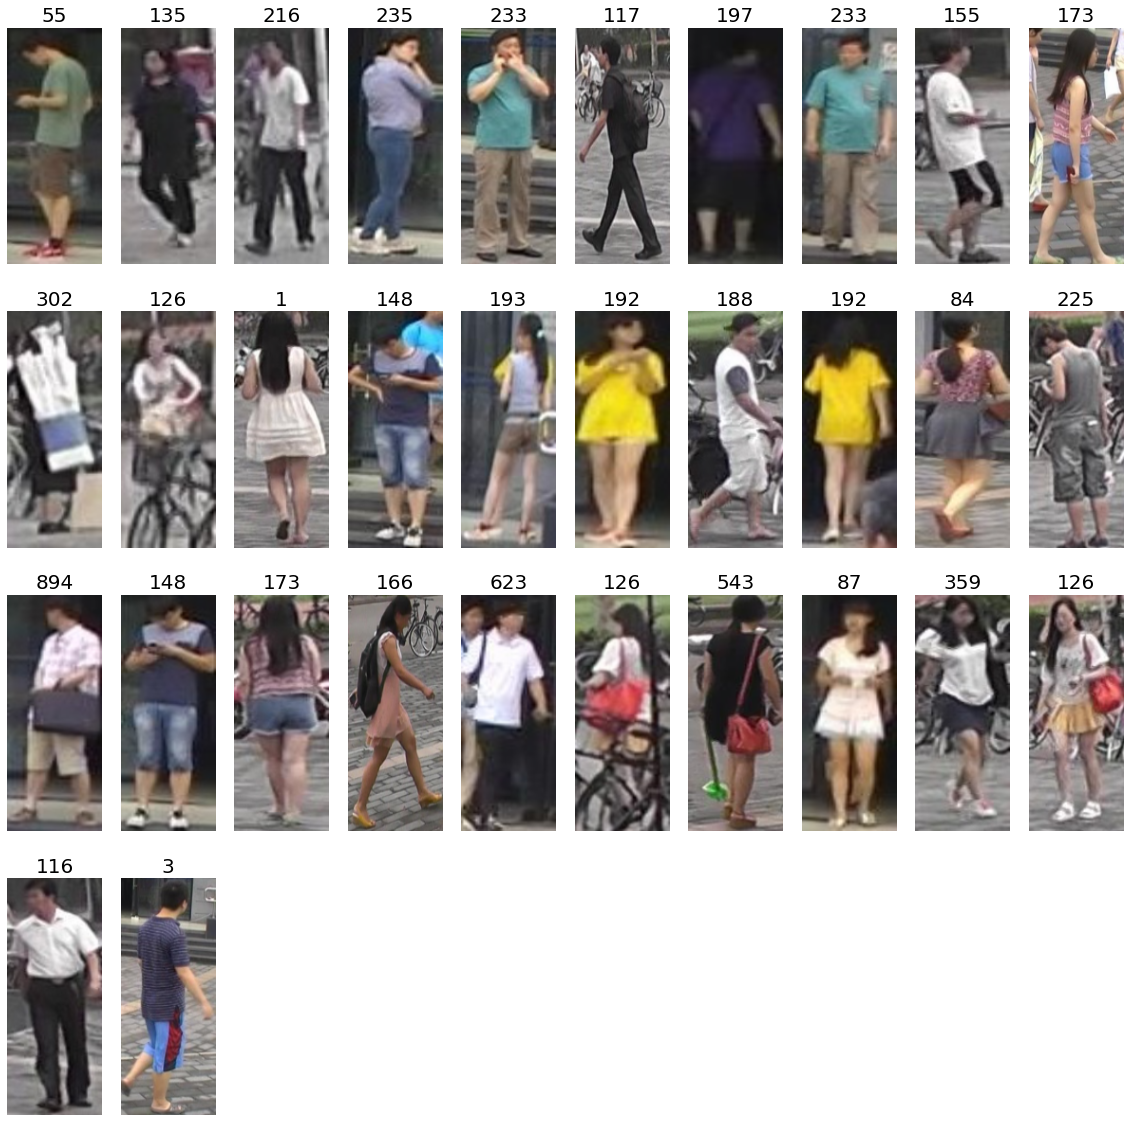

In [11]:
def postprocess(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    out = np.clip(inp, 0, 1)
    out = cv2.resize(out, (100, 250))
    return out

def imshow(inputs, labels, preds=None):
    grid_x, grid_y = len(inputs)//10+1, 10
    plt.figure(figsize=(20, 20))
    """Imshow for Tensor."""
    if preds is None:
        i = 1
        for inp, cls in zip(inputs, labels):
            out = postprocess(inp)
            plt.subplot(grid_x, grid_y, i)
            plt.title(class_names[int(cls)], fontsize=20)
            plt.imshow(out)
            plt.axis('off')
            i+=1
    else:
        i = 1
        for inp, cls, pred in zip(inputs, labels, preds):
            out = postprocess(inp)
            plt.subplot(grid_x, grid_y, i)
            if cls != pred:
                plt.title('pred:'+str(class_names[int(pred)])+'\nlable:'+str(class_names[int(cls)]), color = 'r', fontsize=18)
            else:
                plt.title('pred:'+str(class_names[int(pred)])+'\nlable:'+str(class_names[int(cls)]), fontsize=18)
            plt.imshow(out)
            plt.axis('off')
            i+=1        

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
imshow(inputs, classes)

## 開始訓練模型

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_history = {'train_loss':[], 'valid_loss':[], 'train_acc':[], 'valid_acc':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            train_history[phase+'_loss'].append(epoch_loss)
            train_history[phase+'_acc'].append(float(epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return train_history, model

In [13]:
train_history, model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                      num_epochs=10)
torch.save(model_ft, 'reid_model.pth')

Epoch 0/9
----------


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 3.5581 Acc: 0.2606
valid Loss: 2.8210 Acc: 0.4154
Epoch 1/9
----------
train Loss: 1.1814 Acc: 0.7875
valid Loss: 1.7105 Acc: 0.6564
Epoch 2/9
----------
train Loss: 0.3677 Acc: 0.9583
valid Loss: 1.3172 Acc: 0.7538
Epoch 3/9
----------
train Loss: 0.1323 Acc: 0.9928
valid Loss: 1.0967 Acc: 0.7795
Epoch 4/9
----------
train Loss: 0.0579 Acc: 1.0000
valid Loss: 1.0280 Acc: 0.7897
Epoch 5/9
----------
train Loss: 0.0379 Acc: 1.0000
valid Loss: 1.0158 Acc: 0.7897
Epoch 6/9
----------
train Loss: 0.0354 Acc: 1.0000
valid Loss: 1.0150 Acc: 0.7949
Epoch 7/9
----------
train Loss: 0.0317 Acc: 1.0000
valid Loss: 1.0064 Acc: 0.8000
Epoch 8/9
----------
train Loss: 0.0320 Acc: 1.0000
valid Loss: 0.9957 Acc: 0.8000
Epoch 9/9
----------
train Loss: 0.0320 Acc: 1.0000
valid Loss: 1.0000 Acc: 0.7949
Training complete in 0m 17s
Best valid Acc: 0.800000


## 訓練結果視覺化

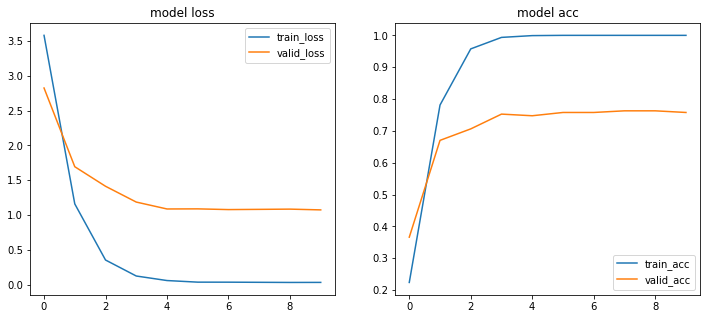

In [19]:
plt.figure(figsize=(12, 5))
for i, (k, v) in enumerate(train_history.items()):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    plt.plot(np.arange(len(v)), v, label=k)
    plt.legend(loc='best')
    plt.title('model '+ k.split('_')[-1])
plt.show()

## 顯示預測結果

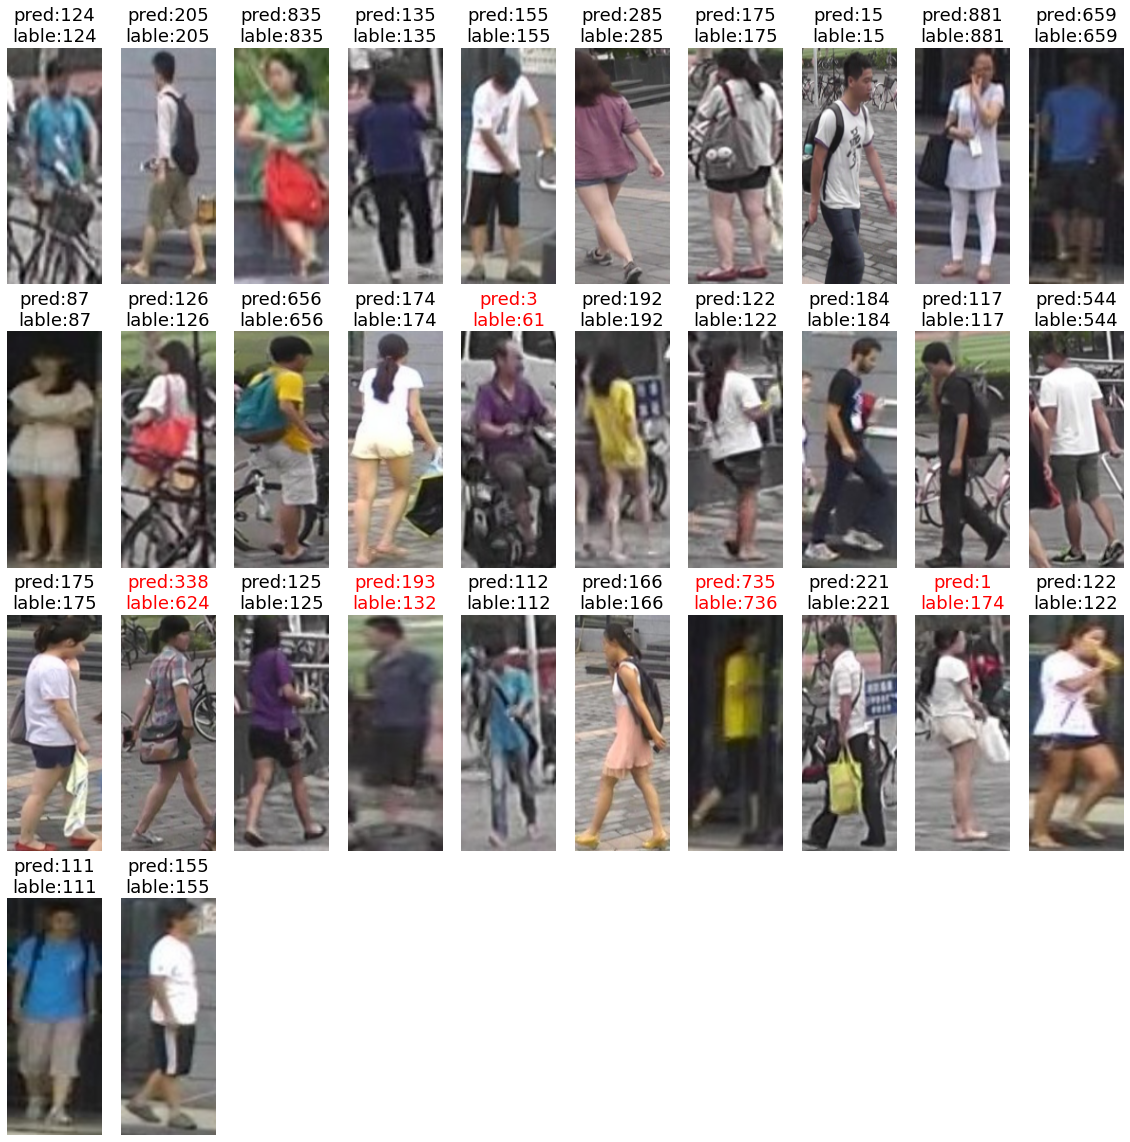

In [20]:
def visualize_model(model):
    was_training = model.training
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(dataloaders['valid']))
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        imshow(inputs.cpu(), labels.cpu(), preds.cpu())
        model.train(mode = was_training)
visualize_model(model_ft)